# PCA used to a classification task using Eigenface dataset

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.util import img_as_float
from os.path import isfile, join, exists
from os import listdir
from skimage import io

## Download the images

In [2]:
path_class= 'yalefaces_dataset' # folder

# retrieve the list of files in the folder
only_files_class = [f for f in listdir(path_class) if isfile(join(path_class, f))]

In [3]:
nfc=len(only_files_class)
faces={}

for i in range(1,16):
    faces[i]=[] # initialize the dictionary to store the image

for i in range(nfc):
    img=only_files_class[i] # take each file
    imgSplit=img.split(".") 
    subject=imgSplit[0] # name of the file
    number = (subject[-2:]) # number of the subject
    
    if len(number)==2:
      number = int((subject[-2:]))
      # read the image and convert as float
      imgR = img_as_float(io.imread(join(path_class, img))) 
      imgR = np.asarray(imgR) # convert in a numpy array
      faces[number].append(imgR) 

Put the images in a tensor, that is a matrix with three dimensions. We divide the images in two sets, the first one is called train set and is used to find the preliminary information, the second one is called test set and is used to test the algorithm. In this example, we simply choose the first seven images of each subject as training dataset, and the remaining three as test set.

In [4]:
imgAT = []
imgTest =[]
for i in range(1,16):
    for j in range(7):
      imgAT.append(np.asarray(faces[i][j]))
    for j in range(7,11):
      imgTest.append(np.asarray(faces[i][j]))
    
imgAT = np.asarray(imgAT)
(nt,nr,nc)=imgAT.shape

print(f'Tensor dim for training dataset: n_images = {nt}, n_rows = {nr}, n_cols = {nc}')
imgTest = np.asarray(imgTest)

(nf,nr,nc)=imgTest.shape
print(f'Tensor dim for test dataset: n_images = {nf}, n_rows = {nr}, n_cols = {nc}')

Tensor dim for training dataset: n_images = 105, n_rows = 243, n_cols = 320
Tensor dim for test dataset: n_images = 60, n_rows = 243, n_cols = 320


The training and test dataset are tensor, and we have used algorithms which work with matrices. So, we need to vectorize out training and test tensor. This means that we vectorize the image, which is now a vector. We lose something, but anyway, the relation between training and test is preserved. So, we compute two matrices containing all the train and test set images as his columns.

In [5]:
imgA = imgAT.reshape(nt,nr*nc).T
imgTest = imgTest.reshape(nf,nr*nc).T

In [6]:
(nrc,nt)=imgA.shape
print(f'Training dataset: n_rows = {nrc}, n_images (cols) = {nt}')

Training dataset: n_rows = 77760, n_images (cols) = 105


Since we want to perform the PCA, we need to compute the mean image and subtract it to all the images.

In [7]:
imgAsum = np.sum(imgA,axis=1)/nt
print("Mean vector for each face:\n",imgAsum)
print("----------------------------------------")
e = np.ones((1,nt))
imgAM=imgA-np.dot(imgAsum.reshape(nrc,1),e)
print("Shape of the mean vector:", imgAsum.shape)
print("Shape of the original matrix:", imgA.shape)
print("Shape of the matrix after mean subtraction:", imgAM.shape)

Mean vector for each face:
 [0.48022409 0.47966387 0.47936508 ... 0.26666667 0.26666667 0.26666667]
----------------------------------------
Shape of the mean vector: (77760,)
Shape of the original matrix: (77760, 105)
Shape of the matrix after mean subtraction: (77760, 105)


Perform the PCA, using at this moment a fix number of components. Remember that PCA can be performed using the covariance matrix and the correlation matrix.
1) To use the covariance matrix, we set <b>whiten=False</b>.
2) To use the correlation matrix, we set <b>whiten=True</b>; in this way each column will be divided by the standard deviation. 

What are these? Are the basis for the R(A). The subspace that describes all the faces. All the faces, subtracted the mean, are linear combination of these columns. Each faces are linear combination of the basis.


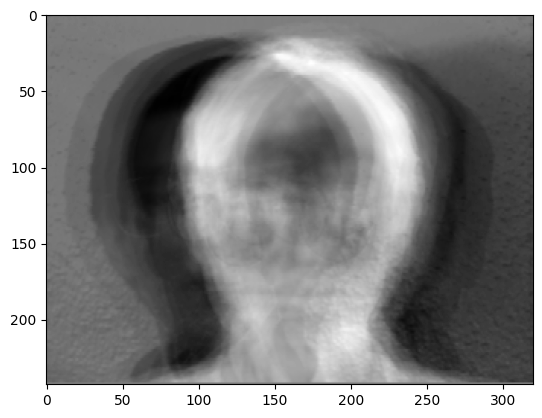

In [8]:
ncomp=20
pca = PCA(copy=True,n_components=ncomp,whiten=True).fit(imgAM)
IM_pca = pca.transform(imgAM)
IM_pca = IM_pca/np.sqrt(nrc) #To make sure that the columns are orthogonal
plt.imshow(IM_pca[:,1].reshape(nr,nc),cmap='gray')
print("What are these? Are the basis for the R(A). The subspace that describes all the faces. All the faces, subtracted the mean, are linear combination of these columns. Each faces are linear combination of the basis." )

Now we choose a test image from our test dataset and we show it.

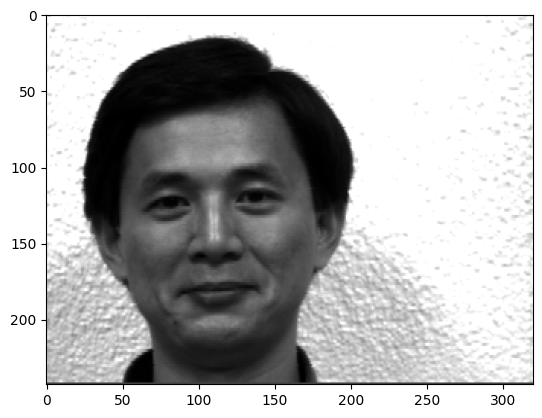

In [9]:
ng = 20
plt.imshow(imgTest[:,ng].reshape(nr,nc),cmap='gray')

Now we would like to compare the coordinates of the projection of the image into the subspace. So, we want to compute the coordinates of the projection of the test image onto the eigenface space. Since we have dropped the mean from each image of the train set, we need to subtract the mean also on the test set.

In [10]:
PT1=imgTest[:,ng]-imgAsum # subtract the mean of the training data
mPT1=np.mean(PT1) # we compute the mean of the matrix then and we drop it
PT1=PT1-mPT1

# these are the coefficients of the projection, not the projection
Ptest=np.dot(IM_pca.T,PT1) #(Ua.T * q) 

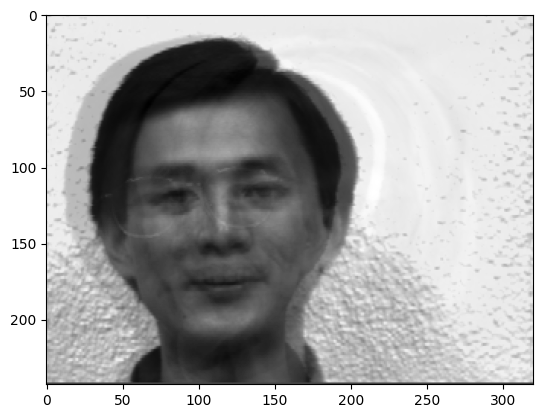

In [11]:
# now we reconstruct the image, and if we compare with the original,
# what we obtain is pretty accurate.
plt.imshow((np.dot(IM_pca,Ptest)+mPT1+imgAsum).reshape(nr,nc),cmap='gray')

Now we need to compute the coefficients for all the people and compare in order to retrieve the correct query. So, compute the class for each face that is the mean of the coordinates of the projection. In our matrix, we have a lot of faces, but a group of faces is related to the same people. Since we have more images for the same people, we compute the coefficients for each image, but then we compute the mean of the coefficients of the same people.

In [12]:
Cli = {}
for i in range(1,16):
    Cli[i]=[]

# Here we are just computing the coefficients (coordinates)
# for each face in the projected space
for i in range(1,16):
     for j in range(7):
       PT1=faces[i][j].reshape(nr*nc)-imgAsum
       mPT1=np.mean(PT1)
       PT1=PT1-np.mean(PT1)
       Pimg=np.dot(IM_pca.T,PT1)
       Cli[i].append(Pimg)
     Cli[i]=np.asarray(Cli[i])
i=15
print(f'Nimg (rows) for faces {i+1} = {Cli[1].shape[0]}, '
      f'Ncoeff (cols) for faces {i} = {Cli[1].shape[1]}')      

Nimg (rows) for faces 16 = 7, Ncoeff (cols) for faces 15 = 20


Once we have computed the coefficients for each face, we reduce the coefficients of the same person just computing the mean. In this way we have one vector of coefficients for each person. 

In [13]:
om = {}
for i in range(1,16):
    om[i]=np.mean(Cli[i],axis=0)    

The simplest method to determine which face class provides the best description of the input is to find the face class that minimize the Euclidean differences of the coordinates in the eigenface basis. We compute the norm for each class.

In [14]:
v = np.zeros((15,1))
for i in range(1,16):
    v[i-1]= np.linalg.norm(om[i]-Ptest)

The class of the test people is: 5


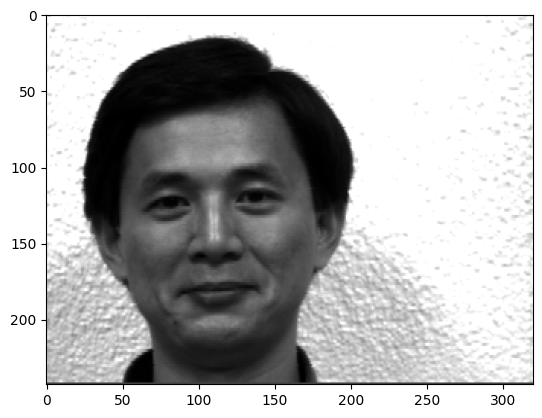

In [15]:
n_class=np.argmin(v)
print('The class of the test people is:', n_class)
plt.imshow(imgTest[:,ng].reshape(nr,nc),cmap='gray')

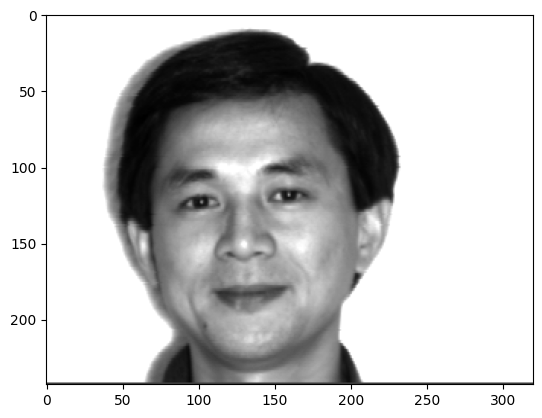

In [16]:
plt.imshow(np.asarray(faces[n_class+1][0]).reshape(nr,nc),cmap='gray')

Exercise 1: check and compare all the studied techniques to find the minimal value of k, number of principal component that are useful to classify the faces

Exercise 2: Classify all the faces in the testset and compute the confusion matrix. The element in position i,j of the confusion matrix  contains the number of observations known to be in group i and predicted to be in group j. Use  sklearn.metrics.confusion_matrix, and compute also the classification report using sklearn.metrics.classification_report